# Import Necessary Modules

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop

# Prepare the 'Cats vs Dogs' Dataset
Download the dataset from https://drive.google.com/file/d/1KWPKw5H5Ltc3D4kQlRmvEaYieMveMej8/view?usp=sharing

## Get a List of all the Raw Images

In [2]:
raw_image_dir = './Datasets/1. Raw/'
raw_image_names = [image for image in os.listdir(
    raw_image_dir) if os.path.isfile(os.path.join(raw_image_dir, image))]
print('Found ' + str(len(raw_image_names)) + ' images!')

Found 3002 images!


## Initialize Variables & Define Functions

In [3]:
# Initialize some required variable(s)
dog_count = 0
cat_count = 0
training_size = 1000
training_images = []
training_labels = []
val_size = 500
val_images = []
val_labels = []
image_dimensions = 150

dog_train_dir = './Datasets/2. Train & Validation/Train/Dog/'
cat_train_dir = './Datasets/2. Train & Validation/Train/Cat/'
dog_val_dir = './Datasets/2. Train & Validation/Validation/Dog/'
cat_val_dir = './Datasets/2. Train & Validation/Validation/Cat/'


# Define some required function(s)
def make_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

## Split the Raw Dataset into Training and Validation Datasets

In [4]:
# -> Make training & validation directories for both of our classes
make_dir(dog_train_dir)
make_dir(cat_train_dir)
make_dir(dog_val_dir)
make_dir(cat_val_dir)

# -> Split the raw dataset into training and validation) datasets
for index, image_name in enumerate(raw_image_names):

    if raw_image_names[index][0] == "d":
        dog_count += 1
        image = cv2.imread(raw_image_dir + image_name)
        image = cv2.resize(
            image, (image_dimensions, image_dimensions), interpolation=cv2.INTER_AREA)
        if dog_count <= training_size:
            training_images.append(image)
            training_labels.append(1)
            cv2.imwrite(dog_train_dir + "dog_" +
                        str(dog_count) + ".jpg", image)
        if dog_count > training_size and dog_count <= (training_size + val_size):
            val_images.append(image)
            val_labels.append(1)
            cv2.imwrite(dog_val_dir + "dog_" +
                        str(dog_count - 1000) + ".jpg", image)

    if raw_image_names[index][0] == "c":
        cat_count += 1
        image = cv2.imread(raw_image_dir + image_name)
        image = cv2.resize(
            image, (image_dimensions, image_dimensions), interpolation=cv2.INTER_AREA)
        if cat_count <= training_size:
            training_images.append(image)
            training_labels.append(0)
            cv2.imwrite(cat_train_dir + "cat_" +
                        str(cat_count) + ".jpg", image)
        if cat_count > training_size and cat_count <= (training_size + val_size):
            val_images.append(image)
            val_labels.append(0)
            cv2.imwrite(cat_val_dir + "cat_" +
                        str(cat_count - 1000) + ".jpg", image)

    if dog_count == (training_size + val_size) and cat_count == (training_size + val_size):
        break

print("Successful!")

Successful!


## Save Our Training & Validation Datasets as NPZ files

In [5]:
# Save our training & validation datasets as NPZ files using numpy's savez function
np.savez('./Datasets/2. Train & Validation/Train/cats_vs_dogs_training_images.npz',
         np.array(training_images))
np.savez('./Datasets/2. Train & Validation/Train/cats_vs_dogs_training_labels.npz',
         np.array(training_labels))
np.savez('./Datasets/2. Train & Validation/Validation/cats_vs_dogs_val_images.npz',
         np.array(val_images))
np.savez('./Datasets/2. Train & Validation/Validation/cats_vs_dogs_val_labels.npz',
         np.array(val_labels))

## Define the Dataset Loader Function

In [6]:
def load_dataset():

    npzfile = np.load(
        './Datasets/2. Train & Validation/Train/cats_vs_dogs_training_images.npz')
    train_images = npzfile['arr_0']

    npzfile = np.load(
        './Datasets/2. Train & Validation/Train/cats_vs_dogs_training_labels.npz')
    train_labels = npzfile['arr_0']

    npzfile = np.load(
        './Datasets/2. Train & Validation/Validation/cats_vs_dogs_val_images.npz')
    val_images = npzfile['arr_0']

    npzfile = np.load(
        './Datasets/2. Train & Validation/Validation/cats_vs_dogs_val_labels.npz')
    val_labels = npzfile['arr_0']

    return (train_images, train_labels), (val_images, val_labels)

# Load the 'Cats vs Dogs' Dataset & Examine it

In [7]:
(x_train, y_train), (x_val, y_val) = load_dataset()

# Some print statements to examine the dataset we have
print("Number of samples in our training data: " + str(len(x_train)))
print("Number of labels in our training data: " + str(len(y_train)))
print("Number of samples in our val data: " + str(len(x_val)))
print("Number of labels in our val data: " + str(len(y_val)))
print()
print("Dimensions of x_train: " + str(x_train.shape))
print("Dimensions of x_val: " + str(x_val.shape))

Number of samples in our training data: 2000
Number of labels in our training data: 2000
Number of samples in our val data: 1000
Number of labels in our val data: 1000

Dimensions of x_train: (2000, 150, 150, 3)
Dimensions of x_val: (1000, 150, 150, 3)


# Preprocessing Our Dataset

## Preprocessing our image datasets i.e x_train & x_val

In [8]:
# Change our image data type to float32 data type
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255
x_val /= 255

## Preprocessing our label datasets i.e y_train & y_val

In [9]:
# Reshaping our label datasets and val data
y_train = y_train.reshape(y_train.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

# Build a Baseline Model

## Create the Model

In [10]:
# Initalize the model using Sequential class from Keras
model1 = Sequential()
# Add first convolutional layer
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                  input_shape=(150, 150, 3), padding="same"))
# Add a pooling layer which will downsample our data
model1.add(MaxPooling2D(pool_size=(2, 2)))
# Add 2nd convolutional layer
model1.add(Conv2D(filters=64, kernel_size=(3, 3),
                  activation='relu', padding="same"))
# Add a pooling layer which will downsample our data
model1.add(MaxPooling2D(pool_size=(2, 2)))
# Add 3rd convolutional layer
model1.add(Conv2D(filters=128, kernel_size=(
    3, 3), activation='relu', padding="same"))
# Add a pooling layer which will downsample our data
model1.add(MaxPooling2D(pool_size=(2, 2)))
# Add a flatten layer which will aid in flattening the input
model1.add(Flatten())
# Add a dense/FC layer
model1.add(Dense(units=256, activation='relu'))
# Add a droput layer which will aid in regularization
model1.add(Dropout(0.5))
# Add a dense/FC layer
model1.add(Dense(units=1, activation='sigmoid'))
# Compile the model
model1.compile(loss='binary_crossentropy',
               optimizer=RMSprop(),
               metrics=['accuracy'])
# Print a summary of our model
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

## Define Callbacks

In [11]:
# Define a callback for saving only the best model during the training
checkpoint = ModelCheckpoint(filepath="./Trained Models/cats_vs_dogs_classifier.h5",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Define a callback to stop training when validation accuracy has stopped increasing
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          patience=3,
                          restore_best_weights=True,
                          verbose=1)

# Put our callbacks into a list
callbacks = [earlystop, checkpoint]

# Train the Baseline Model

In [12]:
batch_size = 32

# Train our model and store the training results in a variable
model1_train_result = model1.fit(x=x_train,
                                 y=y_train,
                                 batch_size=batch_size,
                                 epochs=100,
                                 callbacks=callbacks,
                                 validation_data=(x_val, y_val))

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.1518 - accuracy: 0.5210
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./Trained Models\cats_vs_dogs_classifier.h5
63/63 [==============================] - 5s 78ms/step - loss: 1.1518 - accuracy: 0.5210 - val_loss: 0.8735 - val_accuracy: 0.5000
Epoch 2/100
62/63 [============================>.] - ETA: 0s - loss: 0.6992 - accuracy: 0.5660
Epoch 00002: val_accuracy improved from 0.50000 to 0.54800, saving model to ./Trained Models\cats_vs_dogs_classifier.h5
63/63 [==============================] - 4s 69ms/step - loss: 0.6982 - accuracy: 0.5675 - val_loss: 0.7428 - val_accuracy: 0.5480
Epoch 3/100
62/63 [============================>.] - ETA: 0s - loss: 0.6555 - accuracy: 0.6447
Epoch 00003: val_accuracy improved from 0.54800 to 0.60400, saving model to ./Trained Models\cats_vs_dogs_classifier.h5
63/63 [==============================] - 5s 72ms/step - loss: 0.6549 - accuracy: 0.6455 - val_loss

# Build a New Model Which Utilizes Data Augmentation

## Create a ImageDataGenerator Object

In [13]:
datagen = Image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    dtype='float32')

## Create the Model 

In [14]:
# Initalize the model using Sequential class from Keras
model2 = Sequential()
# Add first convolutional layer
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                  input_shape=(150, 150, 3), padding="same"))
# Add a pooling layer which will downsample our data
model2.add(MaxPooling2D(pool_size=(2, 2)))
# Add 2nd convolutional layer
model2.add(Conv2D(filters=64, kernel_size=(3, 3),
                  activation='relu', padding="same"))
# Add a pooling layer which will downsample our data
model2.add(MaxPooling2D(pool_size=(2, 2)))
# Add 3rd convolutional layer
model2.add(Conv2D(filters=128, kernel_size=(
    3, 3), activation='relu', padding="same"))
# Add a pooling layer which will downsample our data
model2.add(MaxPooling2D(pool_size=(2, 2)))
# Add a flatten layer which will aid in flattening the input
model2.add(Flatten())
# Add a dense/FC layer
model2.add(Dense(units=256, activation='relu'))
# Add a droput layer which will aid in regularization
model2.add(Dropout(0.5))
# Add a dense/FC layer
model2.add(Dense(units=1, activation='sigmoid'))
# Compile the model
model2.compile(loss='binary_crossentropy',
               optimizer=RMSprop(),
               metrics=['accuracy'])
# Print a summary of our model
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)            

# Train the New Model While Performing Real-Time Data Augmentation on Training Dataset

In [15]:
batch_size = 32

# Train our model and store the training results in a variable
model2_train_result = model2.fit(datagen.flow(x=x_train, y=y_train, batch_size=batch_size),
                                 steps_per_epoch=len(x_train) // 32,
                                 epochs=100,
                                 callbacks=callbacks,
                                 validation_data=(x_val, y_val))

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.5122
Epoch 00001: val_accuracy did not improve from 0.73100
62/62 [==============================] - 10s 159ms/step - loss: 0.8355 - accuracy: 0.5122 - val_loss: 0.6731 - val_accuracy: 0.5550
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5539
Epoch 00002: val_accuracy did not improve from 0.73100
62/62 [==============================] - 10s 158ms/step - loss: 0.6884 - accuracy: 0.5539 - val_loss: 0.6915 - val_accuracy: 0.5300
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.5777
Epoch 00003: val_accuracy did not improve from 0.73100
62/62 [==============================] - 10s 161ms/step - loss: 0.6669 - accuracy: 0.5777 - val_loss: 0.6586 - val_accuracy: 0.6060
Epoch 4/100
62/62 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.5996
Epoch 00004: val_accuracy did not improve from 0.73100
62/6

# Evaluate New Model's Performance

## Loss & Accuracy Charts

### Loss Chart

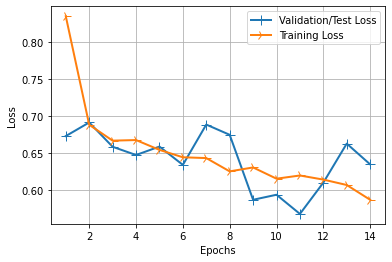

In [16]:
history_dict = model2_train_result.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Accuracy Chart

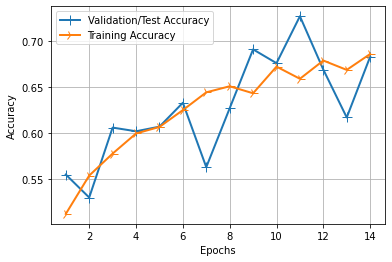

In [17]:
history_dict = model2_train_result.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Classification Report for Validation Dataset

In [18]:
# Get model's predictions for each image in validation dataset
val_pred = model2.predict(x_val, batch_size=batch_size)
val_pred = val_pred.round()

# Get class names
class_names = np.array(['Cat', 'Dog'])

# Get the classification report generated for validation dataset
print(classification_report(y_true=y_val,
                            y_pred=val_pred, target_names=class_names))

              precision    recall  f1-score   support

         Cat       0.70      0.78      0.74       500
         Dog       0.76      0.67      0.71       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



## Confusion Matrix for Validation Dataset

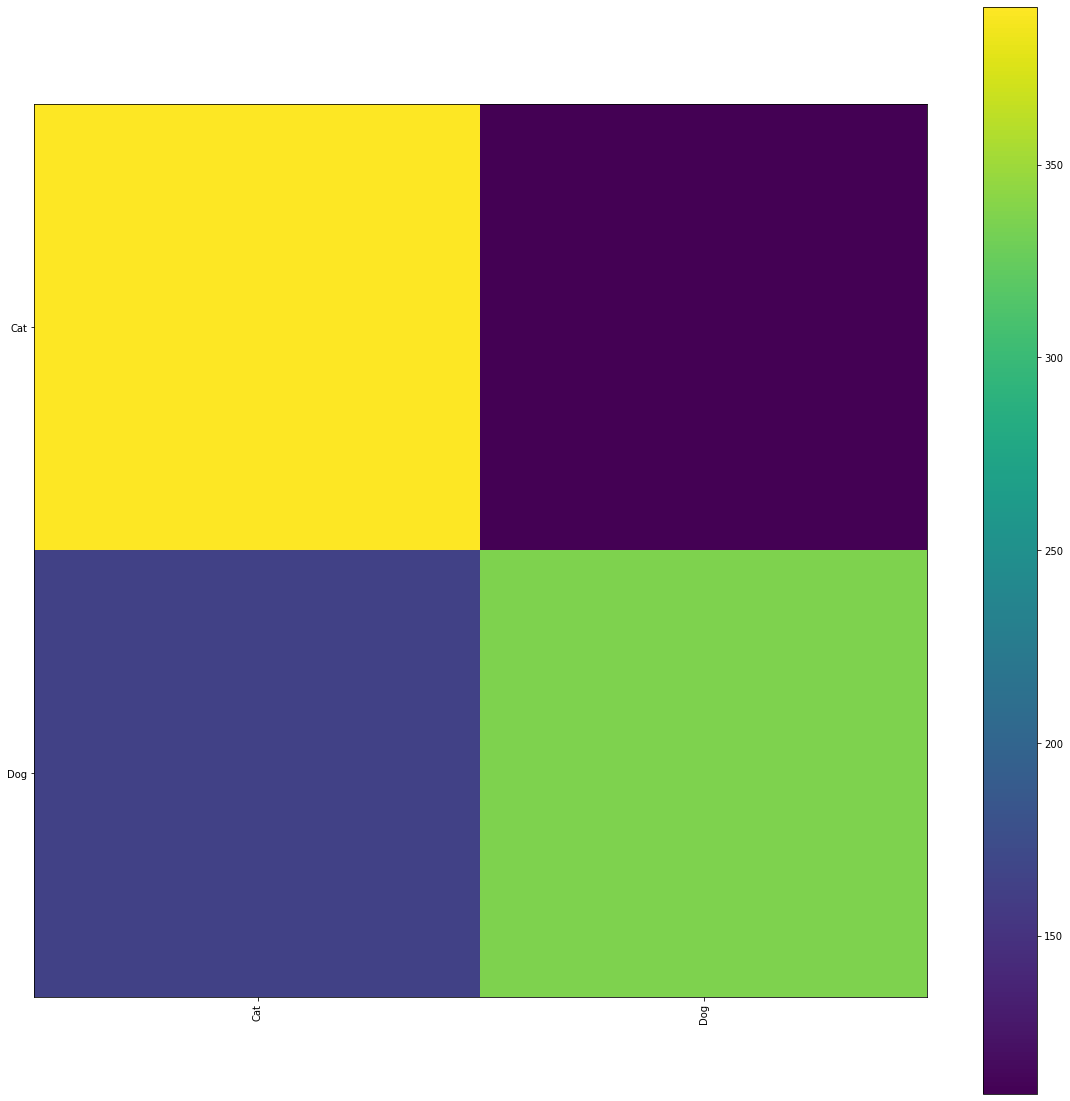

In [19]:
# Generate the confusion matrix for validation dataset
cnf_matrix = confusion_matrix(y_true=y_val, y_pred=val_pred)

# Display the confusion matrix
plt.figure(figsize=(20, 20))
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_names))
_ = plt.xticks(tick_marks, class_names, rotation=90)
_ = plt.yticks(tick_marks, class_names)